# Basic Spatial Anlysis with Python

## Overview
In this lecture, we will investigate the differences between Euclidean distance and Manhattan distance and between Buffer and Convex Hull. To exemplify, we will examine the census block group that is accessible to healthcare resources (i.e., hospitals, emergency medical services, and urgent care) in Champaign County. 

## Data
* Census block group: https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2020&layergroup=Block+Groups
* Healthcare resources: 
    * Hospitals: https://hifld-geoplatform.opendata.arcgis.com/maps/hospitals/about
    * Emergency Medical Service (EMS) Stations: https://hifld-geoplatform.opendata.arcgis.com/datasets/geoplatform::emergency-medical-service-ems-stations/about
    * Urgent Care Facilities: https://hifld-geoplatform.opendata.arcgis.com/datasets/geoplatform::urgent-care-facilities/about

## Glance the difference
### Euclidean distance (4058 feet) vs Manhattan distance (1.2 Miles; 6336 feet)
<img src="./data/euclidean_vs_manhattan.jpg" style="width: 600px;"/>

### Buffer vs Convex Hull

## 1. Data Preparation

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
# Healthcare resources
hc = gpd.read_file('./data/healthcare.shp')
hc.head()

,NAME,TYPE,geometry
0,THE CARLE FOUNDATION HOSPITAL,Hospital,POINT (-88.21495 40.11704)
1,THE PAVILION FOUNDATION,Hospital,POINT (-88.25754 40.11771)
2,OSF HEALTHCARE SYSTEM HEART OF MARY MEDICAL CE...,Hospital,POINT (-88.22711 40.11797)
3,URBANA FIRE RESCUE SERVICES - MAIN STATION,EMS,POINT (-88.20452 40.10999)
4,SAVOY FIRE DEPARTMENT,EMS,POINT (-88.25114 40.06293)


In [3]:
# Census block groups
cbg = gpd.read_file('./data/census_block_group.shp')
cbg.head()

,STATEFP,COUNTYFP,GEOID,geometry
0,17,019,170190008004,"POLYGON ((-88.25812 40.15652, -88.25810 40.156..."
1,17,019,170190109021,"POLYGON ((-88.31384 40.04801, -88.31383 40.048..."
2,17,019,170190014003,"POLYGON ((-88.24917 40.06616, -88.24917 40.066..."
3,17,019,170190008003,"POLYGON ((-88.27710 40.15771, -88.27705 40.157..."
4,17,019,170190109023,"POLYGON ((-88.46265 39.96709, -88.46203 39.967..."


Let's examine the geographical distribution of healthcare resources and census block groups. 
For detail information, Visit `Week6/Geospatial_Data_Visualization.ipynb`. <br>
**Note**: We can specify the order of layers with `zorder` attribute. Higher `zorder` will place the layer on top. 

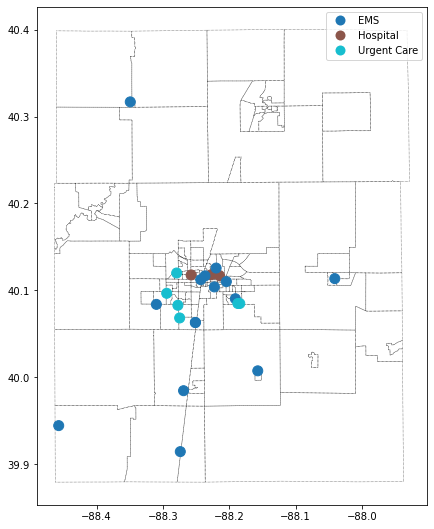

In [4]:
# Plot two layers
fig, ax = plt.subplots(figsize=(7, 10))

hc.plot(ax=ax, column='TYPE', markersize=100, legend=True, zorder=2)
cbg.boundary.plot(ax=ax, linestyle='dotted', lw=0.5, color='black', zorder=1)

plt.show()

You will find that the units (or coordinates) of the maps are decimal degrees (longitude and latitude). As we want to measure the distance between census block groups and healthcare resources, we need to reproject two GeoDataFrame (`hc` and `cbg`) from a geographical coordinate system (NAD83; EPSG 4269) to a projected coordinates system (SPCS83 Illinois East zone (meters); EPSG 26971). 

In [5]:
hc.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [6]:
hc = hc.to_crs(epsg=26971)
cbg = cbg.to_crs(epsg=26971)
hc.crs

<Derived Projected CRS: EPSG:26971>
Name: NAD83 / Illinois East
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Illinois - counties of Boone; Champaign; Clark; Clay; Coles; Cook; Crawford; Cumberland; De Kalb; De Witt; Douglas; Du Page; Edgar; Edwards; Effingham; Fayette; Ford; Franklin; Gallatin; Grundy; Hamilton; Hardin; Iroquois; Jasper; Jefferson; Johnson; Kane; Kankakee; Kendall; La Salle; Lake; Lawrence; Livingston; Macon; Marion; Massac; McHenry; McLean; Moultrie; Piatt; Pope; Richland; Saline; Shelby; Vermilion; Wabash; Wayne; White; Will; Williamson.
- bounds: (-89.28, 37.06, -87.02, 42.5)
Coordinate Operation:
- name: SPCS83 Illinois East zone (meters)
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

## 2. Simple Buffer Analysis

First of all, let's determine how far we can travel within a given time. Here, we assume that **10 minutes** is the threshold travel time and **30 MPH** is the travel speed in the study area. Therefore, the travel distance is 5 Miles. 

\begin{gather*}
Distance = Speed * Time\\
\\
5Miles = 30MPH * \frac{10 minutes} {60 minutes}
\end{gather*}

In [7]:
travel_time = 10
dist = 30 * travel_time / 60

# Translate to Meter per Hour to match the unit with the coordinates system (epsg 26971)
dist = dist * 1.6 * 1000
dist
print(f'{dist} meter is the threshold distance can travel within {travel_time} minutes.')

8000.0 meter is the threshold distance can travel within 10 minutes.


Several ways of doing buffer, but all have the same result. 

In [8]:
# Call buffer from GeoDataFrame
hc_buffer = hc.buffer(dist)
print(type(hc_buffer))
hc_buffer

<class 'geopandas.geoseries.GeoSeries'>


0     POLYGON ((318091.878 383002.829, 318053.356 38...
1     POLYGON ((314461.377 383072.805, 314422.855 38...
2     POLYGON ((317055.291 383104.709, 317016.769 38...
3     POLYGON ((318981.581 382221.278, 318943.059 38...
4     POLYGON ((315012.101 376990.985, 314973.579 37...
5     POLYGON ((297427.513 363812.027, 297388.991 36...
6     POLYGON ((315011.685 376991.399, 314973.163 37...
7     POLYGON ((323037.769 370824.924, 322999.247 37...
8     POLYGON ((317667.772 383956.074, 317629.249 38...
9     POLYGON ((306647.051 405198.482, 306608.529 40...
10    POLYGON ((313082.427 360481.503, 313043.904 35...
11    POLYGON ((332905.397 382639.591, 332866.875 38...
12    POLYGON ((316244.612 382955.738, 316206.090 38...
13    POLYGON ((317445.679 381543.077, 317407.157 38...
14    POLYGON ((309996.706 379305.380, 309958.184 37...
15    POLYGON ((315693.003 382469.623, 315654.481 38...
16    POLYGON ((313495.975 368272.002, 313457.453 36...
17    POLYGON ((320142.619 380036.351, 320104.09

In [9]:
# Call Buffer from GeoSeires (has to be geometry column)
hc_buffer = hc.geometry.buffer(dist)
hc_buffer

0     POLYGON ((318091.878 383002.829, 318053.356 38...
1     POLYGON ((314461.377 383072.805, 314422.855 38...
2     POLYGON ((317055.291 383104.709, 317016.769 38...
3     POLYGON ((318981.581 382221.278, 318943.059 38...
4     POLYGON ((315012.101 376990.985, 314973.579 37...
5     POLYGON ((297427.513 363812.027, 297388.991 36...
6     POLYGON ((315011.685 376991.399, 314973.163 37...
7     POLYGON ((323037.769 370824.924, 322999.247 37...
8     POLYGON ((317667.772 383956.074, 317629.249 38...
9     POLYGON ((306647.051 405198.482, 306608.529 40...
10    POLYGON ((313082.427 360481.503, 313043.904 35...
11    POLYGON ((332905.397 382639.591, 332866.875 38...
12    POLYGON ((316244.612 382955.738, 316206.090 38...
13    POLYGON ((317445.679 381543.077, 317407.157 38...
14    POLYGON ((309996.706 379305.380, 309958.184 37...
15    POLYGON ((315693.003 382469.623, 315654.481 38...
16    POLYGON ((313495.975 368272.002, 313457.453 36...
17    POLYGON ((320142.619 380036.351, 320104.09

In [10]:
# Iterate through the GeoDataFrame and call buffer
for idx, row in hc.iterrows():
    print(row['geometry'].buffer(dist))

POLYGON ((318091.87816100905 383002.829220243, 318053.3559743866 382218.6920976065, 317938.1604042349 381442.10664411396, 317747.4008468667 380680.55180220725, 317482.91442109935 379941.36176132225, 317147.2482757959 379231.655325635, 316743.6350594294 378558.2673560862, 316275.96178791096 377927.6829469338, 315748.73241050146 377345.97497075057, 315167.02443431824 376818.74559334107, 314536.44002516585 376351.07232182263, 313863.05205561704 375947.45910545613, 313153.3456199298 375611.79296015267, 312414.1555790448 375347.3065343853, 311652.60073713807 375156.54697701713, 310876.01528364554 375041.3514068654, 310091.87816100905 375002.829220243, 309307.74103837257 375041.3514068654, 308531.15558488003 375156.54697701713, 307769.6007429733 375347.3065343853, 307030.4107020883 375611.79296015267, 306320.70426640107 375947.45910545613, 305647.31629685225 376351.07232182263, 305016.73188769986 376818.74559334107, 304435.02391151665 377345.97497075057, 303907.79453410715 377927.6829469338,

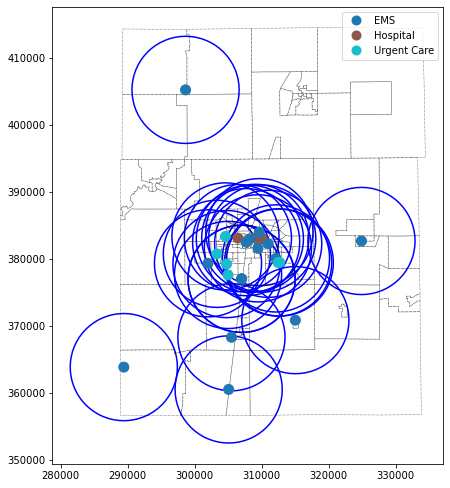

In [11]:
# Plot two layers
fig, ax = plt.subplots(figsize=(7, 10))

hc_buffer.boundary.plot(ax=ax, color='blue', zorder=1)
hc.plot(ax=ax, column='TYPE', markersize=100, legend=True, zorder=2)
cbg.boundary.plot(ax=ax, linestyle='dotted', lw=0.5, color='black', zorder=1)

plt.show()

Given that the type of `hc_buffer` is `GeoSeries` (not `GeoDataFrame`), you can iterate the rows with `GeoSeries.iteritems()`.

In [12]:
for idx, buf in hc_buffer.iteritems():
    print(buf)

POLYGON ((318091.87816100905 383002.829220243, 318053.3559743866 382218.6920976065, 317938.1604042349 381442.10664411396, 317747.4008468667 380680.55180220725, 317482.91442109935 379941.36176132225, 317147.2482757959 379231.655325635, 316743.6350594294 378558.2673560862, 316275.96178791096 377927.6829469338, 315748.73241050146 377345.97497075057, 315167.02443431824 376818.74559334107, 314536.44002516585 376351.07232182263, 313863.05205561704 375947.45910545613, 313153.3456199298 375611.79296015267, 312414.1555790448 375347.3065343853, 311652.60073713807 375156.54697701713, 310876.01528364554 375041.3514068654, 310091.87816100905 375002.829220243, 309307.74103837257 375041.3514068654, 308531.15558488003 375156.54697701713, 307769.6007429733 375347.3065343853, 307030.4107020883 375611.79296015267, 306320.70426640107 375947.45910545613, 305647.31629685225 376351.07232182263, 305016.73188769986 376818.74559334107, 304435.02391151665 377345.97497075057, 303907.79453410715 377927.6829469338,

In [13]:
# The following code will not run. 
# for idx, buf in hc_buffer.iterrows():
#     print(buf)

You may remember that you can slice a `GeoDataFrame` with the function below. Let's see how we can select the census block group within each buffer.  
```python
cbg.loc[cbg.geometry.within()]
```

In [14]:
cbg.loc[cbg.geometry.within(buf)]

,STATEFP,COUNTYFP,GEOID,geometry
2,17,019,170190014003,"POLYGON ((307179.741 377349.506, 307179.910 37..."
10,17,019,170190109015,"POLYGON ((306460.396 371143.798, 306489.735 37..."
12,17,019,170190009014,"POLYGON ((304804.515 384150.781, 305076.325 38..."
15,17,019,170190013023,"POLYGON ((304881.864 377591.621, 304881.966 37..."
17,17,019,170190059021,"POLYGON ((308902.125 382520.506, 308910.053 38..."
...,...,...,...,...
153,17,019,170190010001,"POLYGON ((304302.691 382601.330, 304303.966 38..."
154,17,019,170190011002,"POLYGON ((305636.634 382099.221, 305732.205 38..."
155,17,019,170190011001,"POLYGON ((304831.133 382104.327, 304932.333 38..."
156,17,019,170190012011,"POLYGON ((304040.692 381369.153, 304050.924 38..."


In [15]:
within_cbg = []
for idx, buf in hc_buffer.iteritems():
    temp_gdf = cbg.loc[cbg.geometry.within(buf)]
    within_cbg.extend(temp_gdf['GEOID'].to_list())
    
within_cbg

['170190008004',
 '170190014003',
 '170190008003',
 '170190009014',
 '170190008002',
 '170190059021',
 '170190054011',
 '170190110013',
 '170190056011',
 '170190059011',
 '170190056012',
 '170190056021',
 '170190056015',
 '170190059022',
 '170190056013',
 '170190056014',
 '170190053002',
 '170190009013',
 '170190110012',
 '170190110021',
 '170190110011',
 '170190003013',
 '170190110022',
 '170190003022',
 '170190014001',
 '170190004012',
 '170190012015',
 '170190004022',
 '170190053001',
 '170190054021',
 '170190012013',
 '170190003023',
 '170190054023',
 '170190010004',
 '170190011003',
 '170190055003',
 '170190057014',
 '170190058004',
 '170190054013',
 '170190053004',
 '170190111001',
 '170190058001',
 '170190058005',
 '170190060001',
 '170190060002',
 '170190111002',
 '170190013015',
 '170190058003',
 '170190005003',
 '170190009012',
 '170190003012',
 '170190054012',
 '170190003011',
 '170190002002',
 '170190010002',
 '170190058002',
 '170190002001',
 '170190003021',
 '170190004011

You will notice that the resulted list `within_cbg` is larger than the entire number of census block groups (`cbg`). This is because of duplicates, and `set()` will help you to select only the unique values. 

In [16]:
len(within_cbg)

1540

In [17]:
len(cbg)

158

In [18]:
len(set(within_cbg))

115

Now, we will select the census block groups only within the buffers. Let's use `.loc[]` method to provide our result. <br>
**Note** You can reverse the result by adding `~` in front of the condition.  

In [19]:
cbg.loc[cbg['GEOID'].isin(set(within_cbg))]

,STATEFP,COUNTYFP,GEOID,geometry
0,17,019,170190008004,"POLYGON ((306407.568 387381.633, 306409.506 38..."
2,17,019,170190014003,"POLYGON ((307179.741 377349.506, 307179.910 37..."
3,17,019,170190008003,"POLYGON ((304790.796 387513.235, 304795.054 38..."
7,17,019,170190056022,"POLYGON ((312959.265 380709.613, 312959.681 38..."
9,17,019,170190009023,"POLYGON ((298501.876 385793.938, 298529.400 38..."
...,...,...,...,...
153,17,019,170190010001,"POLYGON ((304302.691 382601.330, 304303.966 38..."
154,17,019,170190011002,"POLYGON ((305636.634 382099.221, 305732.205 38..."
155,17,019,170190011001,"POLYGON ((304831.133 382104.327, 304932.333 38..."
156,17,019,170190012011,"POLYGON ((304040.692 381369.153, 304050.924 38..."


In [20]:
cbg.loc[~cbg['GEOID'].isin(set(within_cbg))]

,STATEFP,COUNTYFP,GEOID,geometry
1,17,019,170190109021,"POLYGON ((301663.744 375331.378, 301664.492 37..."
4,17,019,170190109023,"POLYGON ((288952.382 366354.051, 289005.181 36..."
5,17,019,170190109022,"POLYGON ((288934.725 376118.484, 288971.586 37..."
6,17,019,170190106034,"POLYGON ((288928.268 386475.420, 288982.045 38..."
8,17,019,170190107024,"POLYGON ((317702.422 394957.748, 318080.997 39..."
13,17,019,170190109012,"POLYGON ((308108.961 376042.803, 308294.454 37..."
19,17,019,170190107021,"POLYGON ((326766.968 386659.430, 326935.680 38..."
24,17,019,170190107022,"POLYGON ((328899.667 378591.290, 328899.654 37..."
33,17,019,170190109024,"POLYGON ((297915.653 356685.018, 297940.834 35..."
46,17,019,170190106012,"POLYGON ((293289.059 391362.401, 293297.097 39..."


In [21]:
y_buffer = cbg.loc[cbg['GEOID'].isin(set(within_cbg))]
n_buffer = cbg.loc[~cbg['GEOID'].isin(set(within_cbg))]

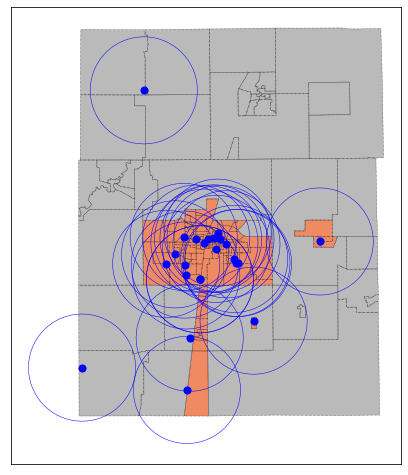

In [54]:
# Plot two layers
fig, ax = plt.subplots(figsize=(7, 10))

hc_buffer.boundary.plot(ax=ax, color='blue', lw=0.5, zorder=2)
y_buffer.plot(ax=ax, color='#ef8a62', zorder=1)
n_buffer.plot(ax=ax, color='#bababa', zorder=1)

hc.plot(ax=ax, markersize=50, color='blue', zorder=2)
cbg.boundary.plot(ax=ax, linestyle='dotted', lw=0.5, color='black', zorder=1)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

You may think having a large number of buffer make the map complicated and want to dissolve/union the buffer. You can use `.unary_union` for this purpose. 
**Note** The result of `unary_union` has the type of `Shapely`. You need to convert it back to `GeoSeries` or `GeoDataFrame` for plotting. 

<class 'shapely.geometry.multipolygon.MultiPolygon'>


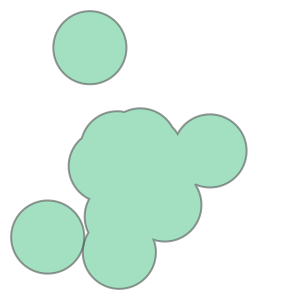

In [23]:
hc_buffer_union = hc.geometry.buffer(dist).unary_union
print(type(hc_buffer_union))
# hc_buffer.plot()   # Shapely does not have a method .plot()
hc_buffer_union

<class 'geopandas.geoseries.GeoSeries'>


<AxesSubplot:>

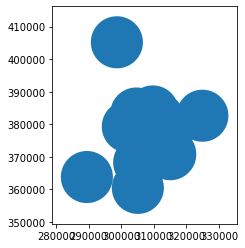

In [24]:
hc_buffer_union = gpd.GeoSeries(hc_buffer_union)
print(type(hc_buffer_union))
hc_buffer_union.plot()

Given that the aggregated buffer only has a row, you don't need to iterate every row to select census block groups. Instead, you can use the following one line. 

In [25]:
cbg.loc[cbg.geometry.within(hc_buffer_union[0])]

,STATEFP,COUNTYFP,GEOID,geometry
0,17,019,170190008004,"POLYGON ((306407.568 387381.633, 306409.506 38..."
1,17,019,170190109021,"POLYGON ((301663.744 375331.378, 301664.492 37..."
2,17,019,170190014003,"POLYGON ((307179.741 377349.506, 307179.910 37..."
3,17,019,170190008003,"POLYGON ((304790.796 387513.235, 304795.054 38..."
7,17,019,170190056022,"POLYGON ((312959.265 380709.613, 312959.681 38..."
...,...,...,...,...
153,17,019,170190010001,"POLYGON ((304302.691 382601.330, 304303.966 38..."
154,17,019,170190011002,"POLYGON ((305636.634 382099.221, 305732.205 38..."
155,17,019,170190011001,"POLYGON ((304831.133 382104.327, 304932.333 38..."
156,17,019,170190012011,"POLYGON ((304040.692 381369.153, 304050.924 38..."


The following shows that the two approaches (i.e., iteration and unary_union) produce the same outcome. 

In [26]:
y_buffer_1 = cbg.loc[cbg.geometry.within(hc_buffer_union[0])]
n_buffer_1 = cbg.loc[~cbg.geometry.within(hc_buffer_union[0])]

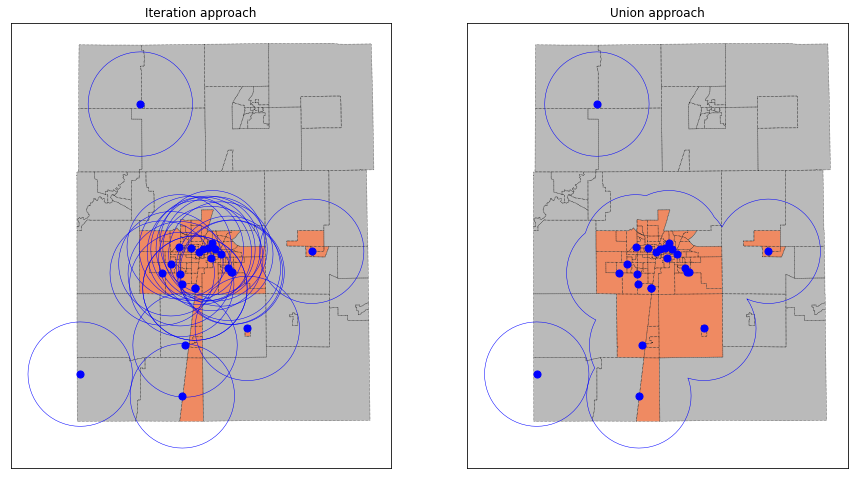

In [53]:
# Plot two layers
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# Iteration approach
hc_buffer.boundary.plot(ax=axes[0], color='blue', lw=0.5, zorder=2)
y_buffer.plot(ax=axes[0], color='#ef8a62', zorder=1)
n_buffer.plot(ax=axes[0], color='#bababa', zorder=1)

## Decoration purpose
hc.plot(ax=axes[0], markersize=50, color='blue', zorder=2)
cbg.boundary.plot(ax=axes[0], linestyle='dotted', lw=0.5, color='black', zorder=1)
axes[0].set_title('Iteration approach')
axes[0].get_xaxis().set_visible(False)
axes[0].get_yaxis().set_visible(False)

# Union Approach
hc_buffer_union.boundary.plot(ax=axes[1], color='blue', lw=0.5, zorder=2)
y_buffer_1.plot(ax=axes[1], color='#ef8a62', zorder=1)
n_buffer_1.plot(ax=axes[1], color='#bababa', zorder=1)

## Decoration purpose
hc.plot(ax=axes[1], markersize=50, color='blue', zorder=2)
cbg.boundary.plot(ax=axes[1], linestyle='dotted', lw=0.5, color='black', zorder=1)
axes[1].set_title('Union approach')
axes[1].get_xaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)

plt.show()

## 3. Euclidean distance

The buffer analysis has some issues of underestimate/overestimate the access. For example, the upper left buffer does not have any census block group selected. <br>
To increase the accuracy of analysis, we can measure the distance between every census block group and healthcare resource. Here, we take advantage of the `.distance()` method of `shapely`. 


In [37]:
hc.head()

,NAME,TYPE,geometry
0,THE CARLE FOUNDATION HOSPITAL,Hospital,POINT (310091.878 383002.829)
1,THE PAVILION FOUNDATION,Hospital,POINT (306461.377 383072.805)
2,OSF HEALTHCARE SYSTEM HEART OF MARY MEDICAL CE...,Hospital,POINT (309055.291 383104.709)
3,URBANA FIRE RESCUE SERVICES - MAIN STATION,EMS,POINT (310981.581 382221.278)
4,SAVOY FIRE DEPARTMENT,EMS,POINT (307012.101 376990.985)


In [38]:
cbg.head()

,STATEFP,COUNTYFP,GEOID,geometry
0,17,019,170190008004,"POLYGON ((306407.568 387381.633, 306409.506 38..."
1,17,019,170190109021,"POLYGON ((301663.744 375331.378, 301664.492 37..."
2,17,019,170190014003,"POLYGON ((307179.741 377349.506, 307179.910 37..."
3,17,019,170190008003,"POLYGON ((304790.796 387513.235, 304795.054 38..."
4,17,019,170190109023,"POLYGON ((288952.382 366354.051, 289005.181 36..."


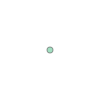

In [58]:
hc.at[0, 'geometry']

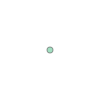

In [63]:
cbg.at[0, 'geometry'].centroid

In [45]:
hc.at[0, 'geometry'].distance(cbg.at[0, 'geometry'].centroid)

4581.967395749192

In [60]:
ori = hc.at[0, 'geometry']
dest = cbg.at[0, 'geometry'].centroid

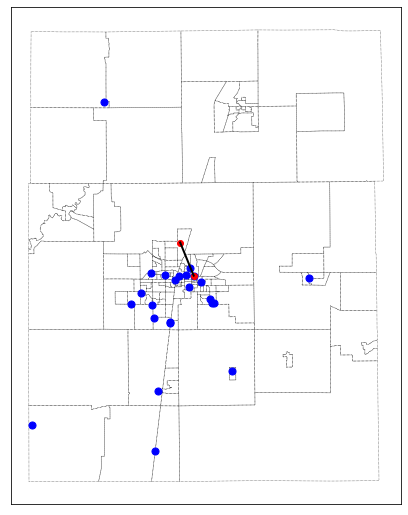

In [70]:
# Plot two layers
fig, ax = plt.subplots(figsize=(7, 10))

# Create points of origin and desitnation and connect them. 
plt.plot(ori.x, ori.y, 'ro')
plt.plot(dest.x, dest.y, 'ro')
plt.plot([ori.x, dest.x], [ori.y, dest.y], color='black', lw=2)

# Decoration
hc.plot(ax=ax, markersize=50, color='blue', zorder=2)
cbg.boundary.plot(ax=ax, linestyle='dotted', lw=0.5, color='black', zorder=1)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

In [88]:
# within_eucli = []

for idx_h, row_h in hc.iterrows():
    for idx_c, row_c in cbg.iterrows():
        
        temp_dist = row_h.geometry.distance(row_c.geometry)
        print(f'From HC {idx_h} to CBG {idx_c}, Distance: {round(temp_dist)} m' )
        
#         if temp_dist < dist:
#             within_eucli.append(row_c['GEOID'])


From HC 0 to CBG 0, Distance: 2467 m
From HC 0 to CBG 1, Distance: 7597 m
From HC 0 to CBG 2, Distance: 3339 m
From HC 0 to CBG 3, Distance: 4178 m
From HC 0 to CBG 4, Distance: 19877 m
From HC 0 to CBG 5, Distance: 10890 m
From HC 0 to CBG 6, Distance: 13534 m
From HC 0 to CBG 7, Distance: 3545 m
From HC 0 to CBG 8, Distance: 7698 m
From HC 0 to CBG 9, Distance: 6867 m
From HC 0 to CBG 10, Distance: 7237 m
From HC 0 to CBG 11, Distance: 13856 m
From HC 0 to CBG 12, Distance: 4115 m
From HC 0 to CBG 13, Distance: 6942 m
From HC 0 to CBG 14, Distance: 11019 m
From HC 0 to CBG 15, Distance: 6062 m
From HC 0 to CBG 16, Distance: 4800 m
From HC 0 to CBG 17, Distance: 528 m
From HC 0 to CBG 18, Distance: 631 m
From HC 0 to CBG 19, Distance: 16701 m
From HC 0 to CBG 20, Distance: 2601 m
From HC 0 to CBG 21, Distance: 13597 m
From HC 0 to CBG 22, Distance: 2146 m
From HC 0 to CBG 23, Distance: 11997 m
From HC 0 to CBG 24, Distance: 18801 m
From HC 0 to CBG 25, Distance: 14549 m
From HC 0 to C

From HC 4 to CBG 81, Distance: 6012 m
From HC 4 to CBG 82, Distance: 5025 m
From HC 4 to CBG 83, Distance: 3658 m
From HC 4 to CBG 84, Distance: 1093 m
From HC 4 to CBG 85, Distance: 29154 m
From HC 4 to CBG 86, Distance: 28671 m
From HC 4 to CBG 87, Distance: 28549 m
From HC 4 to CBG 88, Distance: 29421 m
From HC 4 to CBG 89, Distance: 18360 m
From HC 4 to CBG 90, Distance: 10893 m
From HC 4 to CBG 91, Distance: 30891 m
From HC 4 to CBG 92, Distance: 27592 m
From HC 4 to CBG 93, Distance: 19746 m
From HC 4 to CBG 94, Distance: 15104 m
From HC 4 to CBG 95, Distance: 5844 m
From HC 4 to CBG 96, Distance: 17865 m
From HC 4 to CBG 97, Distance: 2746 m
From HC 4 to CBG 98, Distance: 5615 m
From HC 4 to CBG 99, Distance: 5115 m
From HC 4 to CBG 100, Distance: 29932 m
From HC 4 to CBG 101, Distance: 7456 m
From HC 4 to CBG 102, Distance: 5162 m
From HC 4 to CBG 103, Distance: 28595 m
From HC 4 to CBG 104, Distance: 8408 m
From HC 4 to CBG 105, Distance: 5337 m
From HC 4 to CBG 106, Distance:

From HC 8 to CBG 122, Distance: 3243 m
From HC 8 to CBG 123, Distance: 4862 m
From HC 8 to CBG 124, Distance: 3931 m
From HC 8 to CBG 125, Distance: 6589 m
From HC 8 to CBG 126, Distance: 6034 m
From HC 8 to CBG 127, Distance: 5703 m
From HC 8 to CBG 128, Distance: 6238 m
From HC 8 to CBG 129, Distance: 6543 m
From HC 8 to CBG 130, Distance: 23921 m
From HC 8 to CBG 131, Distance: 7096 m
From HC 8 to CBG 132, Distance: 3691 m
From HC 8 to CBG 133, Distance: 5120 m
From HC 8 to CBG 134, Distance: 4434 m
From HC 8 to CBG 135, Distance: 4912 m
From HC 8 to CBG 136, Distance: 5183 m
From HC 8 to CBG 137, Distance: 5661 m
From HC 8 to CBG 138, Distance: 2363 m
From HC 8 to CBG 139, Distance: 1023 m
From HC 8 to CBG 140, Distance: 0 m
From HC 8 to CBG 141, Distance: 2347 m
From HC 8 to CBG 142, Distance: 2053 m
From HC 8 to CBG 143, Distance: 1816 m
From HC 8 to CBG 144, Distance: 3267 m
From HC 8 to CBG 145, Distance: 3160 m
From HC 8 to CBG 146, Distance: 3671 m
From HC 8 to CBG 147, Dista

From HC 12 to CBG 109, Distance: 1810 m
From HC 12 to CBG 110, Distance: 1744 m
From HC 12 to CBG 111, Distance: 16227 m
From HC 12 to CBG 112, Distance: 656 m
From HC 12 to CBG 113, Distance: 34 m
From HC 12 to CBG 114, Distance: 883 m
From HC 12 to CBG 115, Distance: 866 m
From HC 12 to CBG 116, Distance: 1117 m
From HC 12 to CBG 117, Distance: 1426 m
From HC 12 to CBG 118, Distance: 1584 m
From HC 12 to CBG 119, Distance: 1179 m
From HC 12 to CBG 120, Distance: 575 m
From HC 12 to CBG 121, Distance: 1192 m
From HC 12 to CBG 122, Distance: 1936 m
From HC 12 to CBG 123, Distance: 3468 m
From HC 12 to CBG 124, Distance: 2324 m
From HC 12 to CBG 125, Distance: 5031 m
From HC 12 to CBG 126, Distance: 4367 m
From HC 12 to CBG 127, Distance: 3966 m
From HC 12 to CBG 128, Distance: 4502 m
From HC 12 to CBG 129, Distance: 4823 m
From HC 12 to CBG 130, Distance: 24870 m
From HC 12 to CBG 131, Distance: 5390 m
From HC 12 to CBG 132, Distance: 2159 m
From HC 12 to CBG 133, Distance: 3483 m
From

From HC 16 to CBG 79, Distance: 17250 m
From HC 16 to CBG 80, Distance: 14775 m
From HC 16 to CBG 81, Distance: 14679 m
From HC 16 to CBG 82, Distance: 13473 m
From HC 16 to CBG 83, Distance: 12318 m
From HC 16 to CBG 84, Distance: 8198 m
From HC 16 to CBG 85, Distance: 37930 m
From HC 16 to CBG 86, Distance: 37490 m
From HC 16 to CBG 87, Distance: 37341 m
From HC 16 to CBG 88, Distance: 37691 m
From HC 16 to CBG 89, Distance: 27202 m
From HC 16 to CBG 90, Distance: 12439 m
From HC 16 to CBG 91, Distance: 39689 m
From HC 16 to CBG 92, Distance: 36297 m
From HC 16 to CBG 93, Distance: 27439 m
From HC 16 to CBG 94, Distance: 16624 m
From HC 16 to CBG 95, Distance: 14650 m
From HC 16 to CBG 96, Distance: 26572 m
From HC 16 to CBG 97, Distance: 11021 m
From HC 16 to CBG 98, Distance: 14243 m
From HC 16 to CBG 99, Distance: 13869 m
From HC 16 to CBG 100, Distance: 38711 m
From HC 16 to CBG 101, Distance: 16117 m
From HC 16 to CBG 102, Distance: 14011 m
From HC 16 to CBG 103, Distance: 36774

From HC 20 to CBG 68, Distance: 2315 m
From HC 20 to CBG 69, Distance: 14903 m
From HC 20 to CBG 70, Distance: 530 m
From HC 20 to CBG 71, Distance: 113 m
From HC 20 to CBG 72, Distance: 2945 m
From HC 20 to CBG 73, Distance: 25953 m
From HC 20 to CBG 74, Distance: 3435 m
From HC 20 to CBG 75, Distance: 5597 m
From HC 20 to CBG 76, Distance: 24909 m
From HC 20 to CBG 77, Distance: 23188 m
From HC 20 to CBG 78, Distance: 15035 m
From HC 20 to CBG 79, Distance: 4151 m
From HC 20 to CBG 80, Distance: 3233 m
From HC 20 to CBG 81, Distance: 3631 m
From HC 20 to CBG 82, Distance: 2309 m
From HC 20 to CBG 83, Distance: 3032 m
From HC 20 to CBG 84, Distance: 2143 m
From HC 20 to CBG 85, Distance: 25460 m
From HC 20 to CBG 86, Distance: 25287 m
From HC 20 to CBG 87, Distance: 24969 m
From HC 20 to CBG 88, Distance: 24473 m
From HC 20 to CBG 89, Distance: 15479 m
From HC 20 to CBG 90, Distance: 6128 m
From HC 20 to CBG 91, Distance: 28454 m
From HC 20 to CBG 92, Distance: 25514 m
From HC 20 to C

In [ ]:
for idx_c, row_c in cbg.iterrows():

    temp_dist = row_h.geometry.distance(row_c.geometry)
    print(f'From HC {idx_h} to CBG {idx_c}, Distance: {round(temp_dist)} m' )

In [89]:
within_eucli

['170190008004',
 '170190109021',
 '170190014003',
 '170190008003',
 '170190056022',
 '170190107024',
 '170190009023',
 '170190109015',
 '170190009014',
 '170190109012',
 '170190013023',
 '170190008002',
 '170190059021',
 '170190054011',
 '170190110013',
 '170190056011',
 '170190009022',
 '170190059011',
 '170190056012',
 '170190056021',
 '170190056015',
 '170190059022',
 '170190056013',
 '170190056014',
 '170190053002',
 '170190009013',
 '170190110012',
 '170190110021',
 '170190110011',
 '170190003013',
 '170190110022',
 '170190003022',
 '170190014001',
 '170190004012',
 '170190012015',
 '170190004022',
 '170190106041',
 '170190053001',
 '170190054021',
 '170190012013',
 '170190012052',
 '170190003023',
 '170190054023',
 '170190010004',
 '170190011003',
 '170190012041',
 '170190055003',
 '170190057014',
 '170190057021',
 '170190058004',
 '170190054013',
 '170190053004',
 '170190054022',
 '170190111001',
 '170190058001',
 '170190058005',
 '170190060001',
 '170190060002',
 '170190111002

In [90]:
set(within_eucli)

{'170190002001',
 '170190002002',
 '170190003011',
 '170190003012',
 '170190003013',
 '170190003021',
 '170190003022',
 '170190003023',
 '170190004011',
 '170190004012',
 '170190004021',
 '170190004022',
 '170190005001',
 '170190005002',
 '170190005003',
 '170190005004',
 '170190007001',
 '170190007002',
 '170190007003',
 '170190008001',
 '170190008002',
 '170190008003',
 '170190008004',
 '170190009011',
 '170190009012',
 '170190009013',
 '170190009014',
 '170190009021',
 '170190009022',
 '170190009023',
 '170190010001',
 '170190010002',
 '170190010003',
 '170190010004',
 '170190010005',
 '170190011001',
 '170190011002',
 '170190011003',
 '170190012011',
 '170190012012',
 '170190012013',
 '170190012014',
 '170190012015',
 '170190012031',
 '170190012032',
 '170190012033',
 '170190012041',
 '170190012051',
 '170190012052',
 '170190012061',
 '170190013011',
 '170190013012',
 '170190013013',
 '170190013014',
 '170190013015',
 '170190013021',
 '170190013022',
 '170190013023',
 '170190014001

In [91]:
y_eucli = cbg.loc[cbg['GEOID'].isin(set(within_eucli))]
n_eucli = cbg.loc[~cbg['GEOID'].isin(set(within_eucli))]

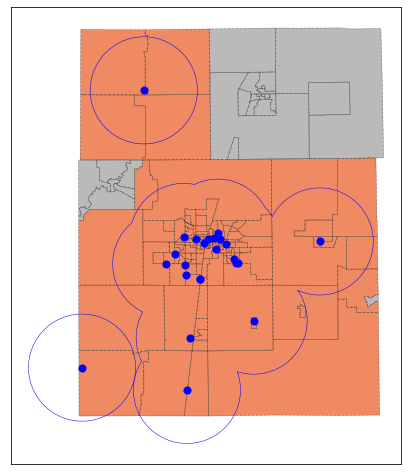

In [94]:
# Plot two layers
fig, ax = plt.subplots(figsize=(7, 10))

hc_buffer_union.boundary.plot(ax=ax, color='blue', lw=0.5, zorder=2)
y_eucli.plot(ax=ax, color='#ef8a62', zorder=1)
n_eucli.plot(ax=ax, color='#bababa', zorder=1)

hc.plot(ax=ax, markersize=50, color='blue', zorder=2)
cbg.boundary.plot(ax=ax, linestyle='dotted', lw=0.5, color='black', zorder=1)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()